# L2-normalized spatial attention network for accurate and fast classification of brain tumors

[https://arxiv.org/pdf/2308.00491.pdf](https://arxiv.org/pdf/2308.00491.pdf)

The article aims to implement attention-mechanism based neural network for classification task.  
Usually, attention mechanisms widely used for segmentation tasks. Here the author proposed an architecture that surpasses state-of-the art network archhitectures for such a classification task

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

from skimage.io import imsave
from sklearn.preprocessing import minmax_scale
from PIL import Image

import os
import random
import h5py
from sys import platform
from tqdm import tqdm

# from google.colab import files

torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
using_colab = False
platform, device

ROOT_DIR_DATASET = 'Datasets/BrainTumorDataset/'

## Data preparation

In [2]:
# %%bash
# mkdir -p data/{train/{meningioma,glioma,pituitary_tumor},test,val/{meningioma,glioma,pituitary_tumor}}
# mkdir dataset
# mkdir outputs

# wget -q https://figshare.com/ndownloader/files/3381290/brainTumorDataPublic_1-766.zip
# wget -q https://figshare.com/ndownloader/files/3381293/brainTumorDataPublic_1533-2298.zip
# wget -q https://figshare.com/ndownloader/files/3381296/brainTumorDataPublic_767-1532.zip
# wget -q https://figshare.com/ndownloader/files/3381302/brainTumorDataPublic_2299-3064.zip

# unzip -q brainTumorDataPublic_1-766.zip -d dataset
# unzip -q brainTumorDataPublic_767-1532.zip -d dataset
# unzip -q brainTumorDataPublic_1533-2298.zip -d dataset
# unzip -q brainTumorDataPublic_2299-3064.zip -d dataset


In [3]:
if using_colab:
  RAW_DATA_DIR = 'dataset'
  _, _, files = next(os.walk(os.path.join(RAW_DATA_DIR)))

  indices = list(range(1, 3064))
  np.random.shuffle(indices)

  train_size = int(0.7 * len(indices))
  test_size = int(0.2 * len(indices))
  val_size = int(0.1 * len(indices))

  train_indices = indices[:train_size]
  test_indices = indices[train_size:train_size + test_size]
  val_indices = indices[train_size + test_size:]

  train_labels = []
  test_labels = []
  val_labels = []

  # Training data
  for i in range(train_size):
    f = os.path.join(RAW_DATA_DIR, files[train_indices[i]])
    data = h5py.File(f,'r')
    label = np.array(data.get('cjdata/label'))[0][0].astype(np.uint16)
    img = np.array(data.get('cjdata/image'))
    img = minmax_scale(img, feature_range=(0, 255)).astype(np.uint8)
    img = np.stack((img,)*3, axis=-1) # Convert to pseudo-RGB
    img_name = files[train_indices[i]].split('.')[0]

    if label == 1:
      imsave(os.path.join('data', 'train', 'meningioma', img_name + '.png'), img)
      train_labels.append([img_name, 1])
    elif label == 2:
      imsave(os.path.join('data', 'train', 'glioma', img_name + '.png'), img)
      train_labels.append([img_name, 2])
    elif label == 3:
      imsave(os.path.join('data', 'train', 'pituitary_tumor', img_name + '.png'), img)
      train_labels.append([img_name, 3])

  # Validation data
  for i in range(len(indices) - (train_size + test_size)):
    f = os.path.join(RAW_DATA_DIR, files[val_indices[i]])
    data = h5py.File(f,'r')
    label = np.array(data.get('cjdata/label'))[0][0].astype(np.int32)
    img = np.array(data.get('cjdata/image'))
    img = minmax_scale(img, feature_range=(0, 255)).astype(np.uint8)
    img = np.stack((img,)*3, axis=-1) # Convert to pseudo-RGB
    img_name = files[val_indices[i]].split('.')[0]

    if label == 1:
      imsave(os.path.join('data', 'val', 'meningioma', img_name + '.png'), img)
      val_labels.append([img_name, 1])
    elif label == 2:
      imsave(os.path.join('data', 'val', 'glioma', img_name + '.png'), img)
      val_labels.append([img_name, 2])
    elif label == 3:
      imsave(os.path.join('data', 'val', 'pituitary_tumor', img_name + '.png'), img)
      val_labels.append([img_name, 3])

  # Test data
  for i in range(test_size):
    f = os.path.join(RAW_DATA_DIR, files[test_indices[i]])
    data = h5py.File(f,'r')
    label = np.array(data.get('cjdata/label'))[0][0].astype(np.int32)
    img = np.array(data.get('cjdata/image'))
    img = minmax_scale(img, feature_range=(0, 255)).astype(np.uint8)
    img = np.stack((img,)*3, axis=-1) # Convert to pseudo-RGB
    img_name = int(files[test_indices[i]].split('.')[0])

    if label == 1:
      test_labels.append([img_name, 1])
    elif label == 2:
      test_labels.append([img_name, 2])
    elif label == 3:
      test_labels.append([img_name, 3])

    imsave(os.path.join('data', 'test', str(img_name) + '.png'), img)

  train_df = pd.DataFrame(columns=['image', 'label'], data=train_labels)
  train_df.to_csv('data/train_labels.csv', index=False)

  test_df = pd.DataFrame(columns=['image', 'label'], data=test_labels)
  test_df.to_csv('data/test_labels.csv', index=False)

  val_df = pd.DataFrame(columns=['image', 'label'], data=val_labels)
  val_df.to_csv('data/val_labels.csv', index=False)

In [4]:
# if using_colab:
#     !zip -r -q data.zip data
#     files.download('data.zip')
#     files.download('dataset.zip')

## Dataset and Dataloader

According to the article, the dataset contains 708
Meningiomas, 1426 Gliomas and 930 Pituitary tumors (3064 images in total).  
As the dataset is imbalanced, we compute weights for each class, as the inverse of the frequency of each class.

In [4]:
batch_size = 64
# class_weight = torch.tensor([3064/1429, 3064/708, 3064/930])
# class_weight.to(device)


transforms = T.Compose([
    T.Resize([256, 256]),
    T.ToTensor()
])


train_set = ImageFolder(root=f'{ROOT_DIR_DATASET}/data/train', transform=transforms)
val_set = ImageFolder(root=f'{ROOT_DIR_DATASET}/data/val', transform=transforms)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

## $l2$-Spatial Attention Block (SAB)

Attention maps are computed as follows :

$$x_{diff}=\sigma(f^{K\times K}(l_2(maxpool(x)) - l_2(minpool(x))))$$

In [5]:
class SAB(nn.Module):

    def __init__(self, kernel_size, in_channels):
        super(SAB, self).__init__()
        self.kernel_size = kernel_size
        self.in_channels = in_channels

        self.conv = nn.Conv2d(self.in_channels, 1, self.kernel_size, padding='same')

        self.l2 = lambda x : F.normalize(x, p=2.)

    def maxpool(self, x):
        return torch.max(x, dim=0, keepdim=True)[0]

    def minpool(self, x):
        return torch.min(x, dim=0, keepdim=True)[0]

    def forward(self, x):
        x_diff = self.l2(self.maxpool(x)) - self.l2(self.minpool(x))
        x_diff = nn.Sigmoid()(self.conv(x_diff))
        out = x * x_diff
        return out


## Network definition

In [6]:
class Classifier(nn.Module):
    def __init__(self, n_features):
      super(Classifier, self).__init__()
      self.n_features = n_features

      self.fc1 = nn.Linear(n_features, 1024)
      self.fc2 = nn.Linear(1024, 256)
      self.fc3 = nn.Linear(256, 3)

    def forward(self, x):
        x = nn.ReLU()(nn.Flatten()(x))
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        # x = nn.Softmax()(self.fc3(x))
        x = self.fc3(x)

        return x


class Net(nn.Module):

    def __init__(self, in_channels=3):
        super(Net, self).__init__()

        # Kernel sizes
        self.k_s1 = 25
        self.k_s2 = 13
        self.k_s3 = 9

        # Number of channels
        self.ch_0 = in_channels
        self.ch_1 = 64
        self.ch_2 = 128
        self.ch_3 = 256

        # Pool size
        self.pool_1 = (4,4)
        self.pool_2 = (2,2)
        self.pool_3 = (2,2)

        # Spatial Attention Blocks
        self.SAB1 = SAB(16, self.ch_1)
        self.SAB2 = SAB(8, self.ch_2)
        self.SAB3 = SAB(4, self.ch_3)

        self.classifier = Classifier(n_features=self.ch_3*16*16)

        self.conv1 = nn.Conv2d(self.ch_0, self.ch_1, self.k_s1, padding='same')
        self.conv2 = nn.Conv2d(self.ch_1, self.ch_2, self.k_s2, padding='same')
        self.conv3 = nn.Conv2d(self.ch_2, self.ch_3, self.k_s3, padding='same')

        self.maxpool1 = nn.MaxPool2d(self.pool_1)
        self.maxpool2 = nn.MaxPool2d(self.pool_2)
        self.maxpool3 = nn.MaxPool2d(self.pool_3)

        self.l2 = lambda x : F.normalize(x, p=2.)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x_sab1 = self.SAB1(x) * x

        x = self.l2(x) + self.l2(x_sab1)

        x = self.maxpool1(x)
        x = nn.ReLU()(self.conv2(x))
        x_sab2 = self.SAB2(x) * x

        x = self.l2(x) + self.l2(x_sab2)

        x = self.maxpool2(x)
        x = nn.ReLU()(self.conv3(x))
        x_sab3 = self.SAB3(x) * x

        x = self.l2(x) + self.l2(x_sab3)

        x = self.maxpool3(x)

        x = self.classifier(x)

        return x

## Training the network

In [7]:
class SaveBestModel():

  def __init__(self, best_val_loss=float('inf')):
    self.best_val_loss = best_val_loss

  def __call__(self, current_val_loss, model):
    if current_val_loss < self.best_val_loss:
      self.best_val_loss = current_val_loss
      # print(f'Saving model...')
      torch.save(model.state_dict(), 'outputs/best_model.pt')

def save_figures(train_losses, val_losses, train_accuracies, val_accuracies):

  fig, ax = plt.subplots(1, 2, figsize=(12,5))

  ax[0].plot(train_losses, label='Train loss')
  ax[0].plot(val_losses, label='Validation loss')
  ax[0].title('Training and validation losses')
  ax[0].xlabel('Epochs')
  ax[0].ylabel('Loss')
  ax[0].legend()
  plt.savefig('outputs/losses.png')

  ax[1].plot(train_accuracies, label='Train accuracy')
  ax[1].plot(val_accuracies, label='Validation Accuracy')
  ax[1].title('Training and validation accuracies')
  ax[1].xlabel('Epochs')
  ax[1].ylabel('Accuracy')
  ax[1].legend()
  plt.savefig('outputs/accuracies.png')



In [8]:
model = Net().to(device)
n_epochs = 60
lr = 0.01
eps = 0.1
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
save_best_model = SaveBestModel()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(n_epochs):
    # Training step
    model.train()
    train_loss = 0.0
    val_accuracy = 0.0
    correct = 0
    total = 0

    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        out = model(imgs)
        loss = criterion(out, labels)
        train_loss += loss.item()

        _, pred = out.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()

        loss.backward()
        optimizer.step()

    train_accuracy = correct/total
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)


    # Validation step
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
      for batch_idx, (imgs, labels) in enumerate(val_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        out = model(imgs)
        loss = criterion(out, labels)
        val_loss += loss.item()

        _ , pred = out.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()

      val_accuracy = correct/total
      val_accuracies.append(val_accuracy)
      val_losses.append(val_loss)

      print(f'({epoch+1}/{n_epochs}) Train loss : {train_loss:.3f} | Val accuracy : {val_accuracy*100:.3f}%')
      save_best_model(val_loss, model)



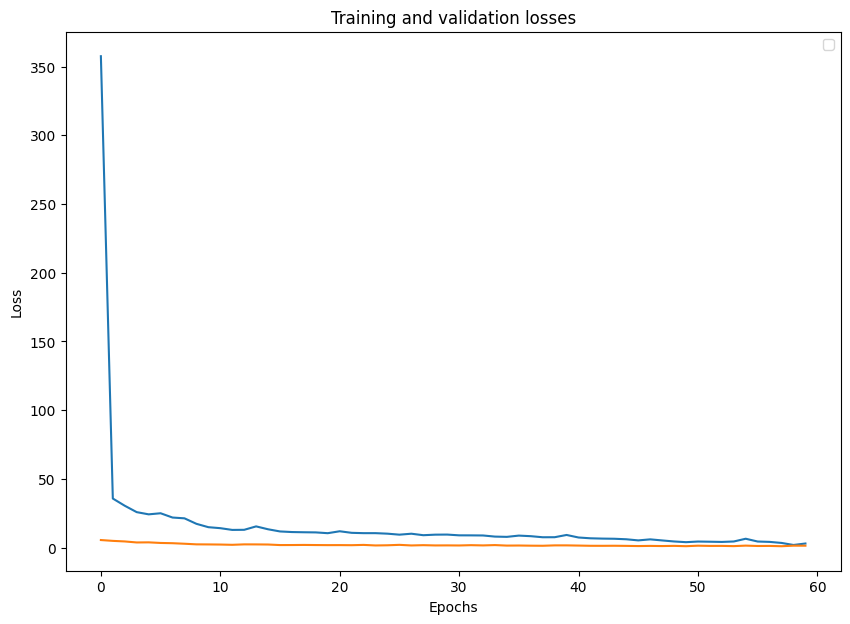

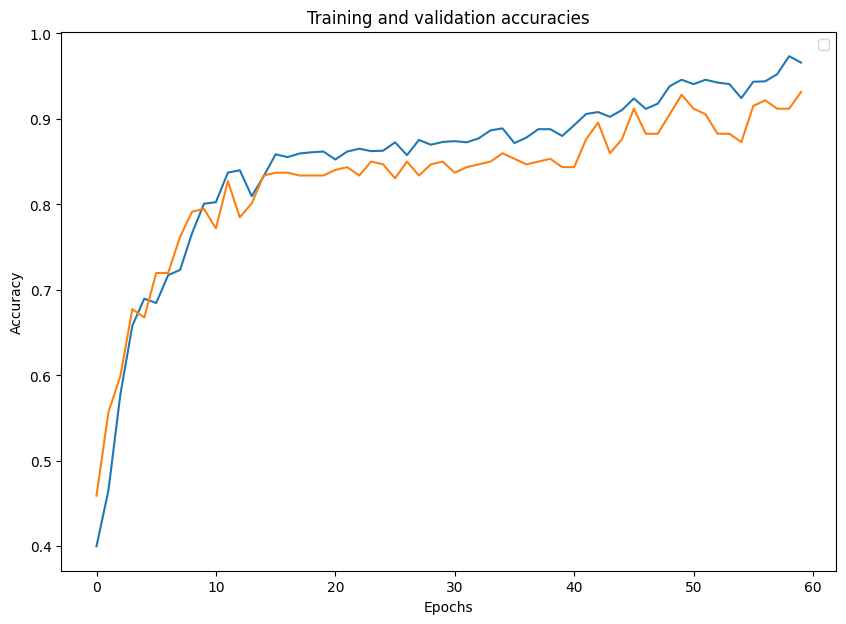

In [11]:
save_figures(train_losses, val_losses, train_accuracies, val_accuracies)

## Test network

In [11]:
best_model = Net()
best_model.load_state_dict(torch.load('Datasets/BrainTumorDataset/outputs/best_model.pt', map_location=device))
best_model.eval()

Net(
  (SAB1): SAB(
    (conv): Conv2d(64, 1, kernel_size=(16, 16), stride=(1, 1), padding=same)
  )
  (SAB2): SAB(
    (conv): Conv2d(128, 1, kernel_size=(8, 8), stride=(1, 1), padding=same)
  )
  (SAB3): SAB(
    (conv): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=same)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=65536, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=3, bias=True)
  )
  (conv1): Conv2d(3, 64, kernel_size=(25, 25), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 128, kernel_size=(13, 13), stride=(1, 1), padding=same)
  (conv3): Conv2d(128, 256, kernel_size=(9, 9), stride=(1, 1), padding=same)
  (maxpool1): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2,

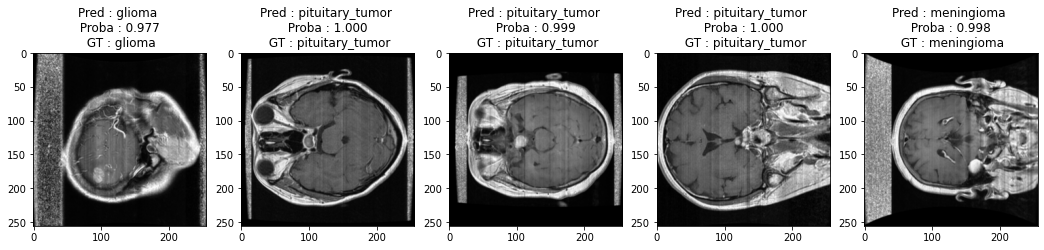

In [66]:
n_samples = 5
fig, ax = plt.subplots(1,n_samples,figsize=(18,10))

for i in range(n_samples):
    idx = random.randint(50, len(val_set) - 1)
    sample = val_set[idx]
    pred = torch.softmax(best_model(sample[0].unsqueeze(0)), dim=1)
    pred_class = torch.argmax(pred.squeeze()).item()
    proba = torch.max(pred.squeeze()).item()
    ax[i].set_title(f'Pred : {val_set.classes[pred_class]} \n Proba : {proba:.3f} \n GT : {val_set.classes[sample[1]]}')
    ax[i].imshow(sample[0].numpy().transpose(1,2,0))
    ax[i].axis('off')
plt.tight_layout()
plt.show()